In [37]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from linearmodels.panel import PanelOLS
from linearmodels.panel import compare


# 데이터 읽기 및 전처리
df_topic_day = pd.read_csv("../../R/data/topic_day_panel.csv")

In [38]:
df_topic_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16100 entries, 0 to 16099
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            16100 non-null  object 
 1   tag             16100 non-null  object 
 2   q_count         16100 non-null  int64  
 3   treat           16100 non-null  int64  
 4   post            16100 non-null  int64  
 5   rel_day         16100 non-null  int64  
 6   rel_week        16100 non-null  int64  
 7   subreddit_name  9982 non-null   object 
 8   subs            9387 non-null   float64
 9   posts           8316 non-null   float64
 10  comments        9044 non-null   float64
 11  rel_month       16100 non-null  int64  
 12  treated         16100 non-null  int64  
 13  fect_id         16100 non-null  int64  
 14  ln_q_count      16100 non-null  float64
dtypes: float64(4), int64(8), object(3)
memory usage: 1.8+ MB


In [42]:
len(df_topic_day['tag'].value_counts())

50

In [44]:
len(df_topic_day['date'].value_counts())

322

In [45]:
print(df_topic_day['date'].min())
print(df_topic_day['date'].max())

2021-10-06
2023-03-14


In [51]:
print(df_topic_day.loc[df_topic_day['treat']==0, 'date'].min())
print(df_topic_day.loc[df_topic_day['treat']==0, 'date'].max())

2021-10-06
2022-03-15


In [52]:
print(df_topic_day.loc[df_topic_day['treat']==1, 'date'].min())
print(df_topic_day.loc[df_topic_day['treat']==1, 'date'].max())

2022-10-05
2023-03-14


In [69]:
df_tmp1 = df_topic_day.loc[df_topic_day['treat']==0, :].head(4)

In [70]:
df_tmp1

,date,tag,q_count,treat,post,rel_day,rel_week,subreddit_name,subs,posts,comments,rel_month,treated,fect_id,ln_q_count
0,2021-10-06,.net,48,0,0,-56,-8,dotnet,102578.0,26.0,150.0,-2,0,1,3.871201
1,2021-10-07,.net,45,0,0,-55,-8,dotnet,102621.0,11.0,95.0,-2,0,1,3.806662
2,2021-10-08,.net,41,0,0,-54,-8,dotnet,102654.0,14.0,97.0,-2,0,1,3.713572
3,2021-10-09,.net,17,0,0,-53,-8,dotnet,102688.0,8.0,119.0,-2,0,1,2.833213


In [71]:
df_tmp2 = df_topic_day.loc[(df_topic_day['treat']==0) &(df_topic_day['tag']=='vue.js'), :].head(3)

In [74]:
pd.concat([df_tmp1,df_tmp2], axis = 0)

,date,tag,q_count,treat,post,rel_day,rel_week,subreddit_name,subs,posts,comments,rel_month,treated,fect_id,ln_q_count
0,2021-10-06,.net,48,0,0,-56,-8,dotnet,102578.0,26.0,150.0,-2,0,1,3.871201
1,2021-10-07,.net,45,0,0,-55,-8,dotnet,102621.0,11.0,95.0,-2,0,1,3.806662
2,2021-10-08,.net,41,0,0,-54,-8,dotnet,102654.0,14.0,97.0,-2,0,1,3.713572
3,2021-10-09,.net,17,0,0,-53,-8,dotnet,102688.0,8.0,119.0,-2,0,1,2.833213
15778,2021-10-06,vue.js,57,0,0,-56,-8,NaN,NaN,NaN,NaN,-2,0,50,4.043051
15779,2021-10-07,vue.js,65,0,0,-55,-8,NaN,NaN,NaN,NaN,-2,0,50,4.174387
15780,2021-10-08,vue.js,61,0,0,-54,-8,NaN,NaN,NaN,NaN,-2,0,50,4.110874


In [72]:
df_topic_day[['date', 'tag']].drop_duplicates()

,date,tag
0,2021-10-06,.net
1,2021-10-07,.net
2,2021-10-08,.net
3,2021-10-09,.net
4,2021-10-10,.net
...,...,...
16095,2023-03-10,vue.js
16096,2023-03-11,vue.js
16097,2023-03-12,vue.js
16098,2023-03-13,vue.js


In [4]:
df_topic_day['date'] = pd.to_datetime(df_topic_day['date'])

In [5]:
# rel_week을 범주형 변수로 변환 (주차별 처리)
df_topic_day['rel_week'] = pd.Categorical(df_topic_day['rel_week'])

In [9]:
df_topic_day = df_topic_day.set_index(['tag', 'date'])

In [7]:
# post와 treat 상호작용 변수 추가 (R의 i(post, ref=0):treat 대응)
# df_topic_day['post_treat'] = df_topic_day['post'] * df_topic_day['treat']

In [10]:
# 고정 효과 모델 (tag를 고정 효과로 포함하고, rel_week도 설명 변수로 포함)
mod_quest_vol_so_dyn = PanelOLS.from_formula('q_count ~ C(rel_week) * treat + EntityEffects',
                                             data=df_topic_day)
result_dyn = mod_quest_vol_so_dyn.fit(cov_type='clustered', cluster_entity=True)


In [11]:
# 동적 효과 계수 추출
coefs = result_dyn.params
std_errors = result_dyn.std_errors
conf_int = result_dyn.conf_int()

In [14]:
periods = np.arange(-7, 15, 1)


In [29]:
[f'C(rel_week)[T.{i}]:treat' for i in periods]

['C(rel_week)[T.-7]:treat',
 'C(rel_week)[T.-6]:treat',
 'C(rel_week)[T.-5]:treat',
 'C(rel_week)[T.-4]:treat',
 'C(rel_week)[T.-3]:treat',
 'C(rel_week)[T.-2]:treat',
 'C(rel_week)[T.-1]:treat',
 'C(rel_week)[T.0]:treat',
 'C(rel_week)[T.1]:treat',
 'C(rel_week)[T.2]:treat',
 'C(rel_week)[T.3]:treat',
 'C(rel_week)[T.4]:treat',
 'C(rel_week)[T.5]:treat',
 'C(rel_week)[T.6]:treat',
 'C(rel_week)[T.7]:treat',
 'C(rel_week)[T.8]:treat',
 'C(rel_week)[T.9]:treat',
 'C(rel_week)[T.10]:treat',
 'C(rel_week)[T.11]:treat',
 'C(rel_week)[T.12]:treat',
 'C(rel_week)[T.13]:treat',
 'C(rel_week)[T.14]:treat']

In [27]:
coefs['C(rel_week)[T.14]:treat']
#     'C(rel_week)[T.14]:treat'

-19.059999999998166

In [30]:
coefs_filtered = coefs.loc[[f'C(rel_week)[T.{i}]:treat' for i in periods]].values
std_errors_filtered = std_errors.loc[[f'C(rel_week)[T.{i}]:treat' for i in periods]].values


In [31]:
# 신뢰구간 계산
ll_95 = coefs_filtered - 1.965 * std_errors_filtered
ul_95 = coefs_filtered + 1.965 * std_errors_filtered

# 데이터프레임 생성 (계수와 신뢰구간)
df_coefs = pd.DataFrame({
    'period': periods,
    'Estimate': coefs_filtered,
    'll_95': ll_95,
    'ul_95': ul_95
})

In [35]:
df_coefs.to_csv('chk.csv')

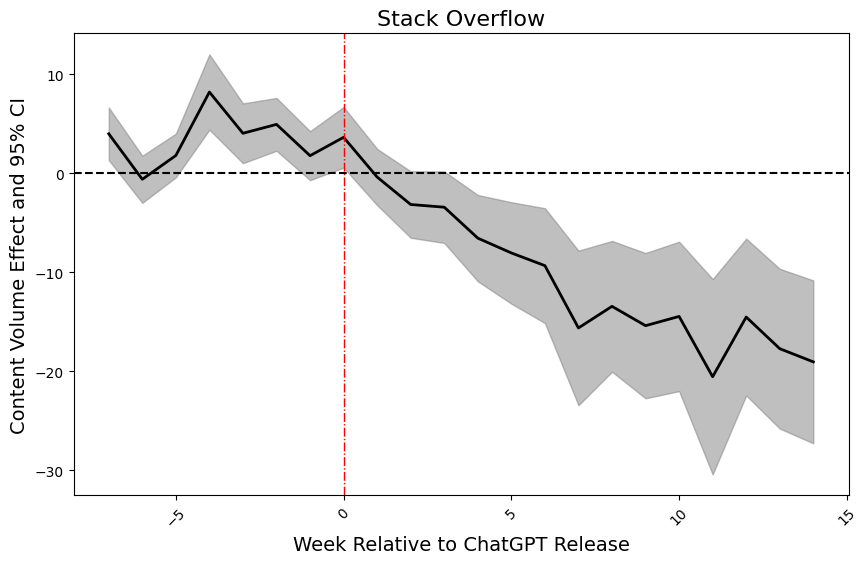

In [32]:
# Plot 그리기
plt.figure(figsize=(10, 6))
plt.fill_between(df_coefs['period'], df_coefs['ll_95'], df_coefs['ul_95'], color='gray', alpha=0.5)
plt.plot(df_coefs['period'], df_coefs['Estimate'], color='black', linewidth=2)
plt.axvline(x=0, color='red', linestyle='-.', linewidth=1)
plt.axhline(y=0, color='black', linestyle='--')

# 그래프 설정
plt.xlabel("Week Relative to ChatGPT Release", fontsize=14)
plt.ylabel("Content Volume Effect and 95% CI", fontsize=14)
plt.title("Stack Overflow", fontsize=16)
plt.xticks(rotation=45)
plt.grid(False)
plt.show()

In [36]:
df_topic_day
-- 알수가 없음....나쁜놈들....

q_count  treat  post  rel_day rel_week subreddit_name  \
tag    date                                                                
.net   2021-10-06       48      0     0      -56       -8         dotnet   
       2021-10-07       45      0     0      -55       -8         dotnet   
       2021-10-08       41      0     0      -54       -8         dotnet   
       2021-10-09       17      0     0      -53       -8         dotnet   
       2021-10-10       13      0     0      -52       -8         dotnet   
...                    ...    ...   ...      ...      ...            ...   
vue.js 2023-03-10       35      1     1      100       14            NaN   
       2023-03-11       18      1     1      101       14            NaN   
       2023-03-12       21      1     1      102       14            NaN   
       2023-03-13       45      1     1      103       14            NaN   
       2023-03-14       47      1     1      104       14            NaN   

                       subs  posts  comments  rel_month  treated  fect_id  \
tag    date                                                                 
.net   2021-10-06  102578.0   26.0     150.0         -2        0        1   
       2021-10-07  102621.0   11.0      95.0         -2        0        1   
       2021-10-08  102654.0   14.0      97.0         -2        0        1   
       2021-10-09  102688.0    8.0     119.0         -2        0        1   
       2021-10-10  102729.0   18.0      90.0         -2        0        1   
...                     ...    ...       ...        ...      ...      ...   
vue.js 2023-03-10       NaN    NaN       NaN          3        1      100   
       2023-03-11       NaN    NaN       NaN          3        1      100   
       2023-03-12       NaN    NaN       NaN          3        1      100   
       2023-03-13       NaN    NaN       NaN          3        1      100   
       2023-03-14       NaN    NaN       NaN          3        1      100   

                   ln_q_count  
tag    date                    
.net   2021-10-06    3.871201  
       2021-10-07    3.806662  
       2021-10-08    3.713572  
       2021-10-09    2.833213  
       2021-10-10    2.564949  
...                       ...  
vue.js 2023-03-10    3.555348  
       2023-03-11    2.890372  
       2023-03-12    3.044522  
       2023-03-13    3.806662  
       2023-03-14    3.850148  

[16100 rows x 13 columns]